# Goal

The goal of this colab is to train a CNN on the IBM-NASA dataset for crop clasification.

# Installation

This module is dedicated for the installation of required packages for the usage of this collab.

In [1]:
!pip install segmentation-models-pytorch torch torchvision torchmetrics datasets albumentations rasterio tqdm pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Imports

In [2]:
import os
import rasterio
import copy
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import time
import json


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from segmentation_models_pytorch import DeepLabV3Plus
from segmentation_models_pytorch.losses import FocalLoss, TverskyLoss
from torch.utils.tensorboard import SummaryWriter


import pandas as pd

from torchmetrics.classification import Accuracy, JaccardIndex
from torchmetrics.segmentation import DiceScore, MeanIoU

from torch.optim.lr_scheduler import PolynomialLR
from torchvision.transforms import ToTensor
from functools import lru_cache
from tqdm import tqdm

# Dataset loading
from datasets import load_dataset

# Google Drive Configuration

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configuration

This block of code will configure all the requried global variables for the project. Some of this variables may have to be changed base on the user so make sure to check them out before executing the program.

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 14

# Trainign
EPOCHS = 50
BATCH_SIZE = 32

# Loading
NUM_WORKERS = 0

# Model params
ENCODER_NAME = "resnet34"
ENCODER_WEIGHTS = None
LEARNING_RATE = 1e-4
DECODER_ATTENTION_TYPE = "scse"
DECODER_USER_NORM = False

# Data directories
DATA_DIR = "/content/drive/MyDrive/Universidad/TFG/Implementations/nasa_ibm/"
UNET_MODEL_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/models/"
UNET_GRAPH_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/"
UNET_METRICS_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/metrics/"

SPLIT_DIR = DATA_DIR + "splited"

TRAINING_IMAGE_DIR = DATA_DIR + "training_chips_merged"
TRAINING_MASK_DIR = DATA_DIR + "training_chips_mask"

VALIDATION_IMAGE_DIR = DATA_DIR + "training_chips_merged"
VALIDATION_MASK_DIR = DATA_DIR + "training_chips_mask"

TEST_IMAGE_DIR = DATA_DIR + "test_chips_merged"
TEST_MASK_DIR = DATA_DIR + "test_chips_mask"

In [5]:
class HFDGeoDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, image_dir, mask_dir, transform=None, is_original_dataset = True ):
        self.dataset = hf_dataset
        self.to_tensor = ToTensor()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.chip_ids = [item['text'] for item in self.dataset]

        self.image_paths = [os.path.join(image_dir, f"{chip_id}_merged.tif")
                           for chip_id in self.chip_ids]
        self.mask_paths = [os.path.join(mask_dir, f"{chip_id}.mask.tif")
                          for chip_id in self.chip_ids]


        self.use_memmap = True

    def __len__(self):
        return len(self.dataset)

    @lru_cache(maxsize=128)  # Cache recently accessed items
    def _load_image(self, image_path):
        """Load image with caching for repeated access."""
        try:
            with rasterio.open(image_path) as src:
                if self.use_memmap:
                    # Try memory-mapped reading when possible
                    image = src.read(out_shape=src.shape, masked=False)
                else:
                    image = src.read()
                return torch.from_numpy(image).type(torch.FloatTensor)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return empty tensor or handle error appropriately
            return torch.zeros((18, 224, 224), dtype=torch.float32)

    @lru_cache(maxsize=128)
    def _load_mask(self, mask_path):
        try:
            with rasterio.open(mask_path) as chip_mask:
                mask = chip_mask.read(1)
                return torch.from_numpy(mask).type(torch.LongTensor)
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            return torch.zeros((224, 224), dtype=torch.long)

    def _normalize_per_band(self, image):
        normalized = np.zeros_like(image, dtype=np.float32)

        for i in range(image.shape[0]):
            band = image[i]
            band_min = band.min()
            band_max = band.max()

            if band_max > band_min:
                normalized[i] = ((band - band_min)/(band_max - band_min))
            else:
                normalized[i] = np.zeros_like(band)

        return torch.from_numpy(normalized).float()

    def __getitem__(self, idx):
        chip_id = self.dataset[idx]['text']
        image_path = self.image_paths[idx]
        mask_path  = self.mask_paths[idx]

        image = self._load_image(image_path)
        mask  = self._load_mask(mask_path)

        image = self._normalize_per_band(image)


        return image, mask





def create_datasets(dataset, image_dirs, mask_dirs, transform = None):
    # Create train and validation datasets
    train_dataset = HFDGeoDataset(
        dataset['train'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    val_dataset = HFDGeoDataset(
        dataset['validation'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    return train_dataset, val_dataset

def create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE, ):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=True,
    )

    return train_loader, val_loader


def visualize_random_rgb_sample(dataset, bands=(2, 1, 0), figsize=(10, 5)):
    """
    Picks a random sample and displays specified bands as an RGB composite,
    with per-band min/max normalization for proper visibility.

    Args:
        dataset: your HFDGeoDataset instance
        bands (tuple of int): which bands to use for R, G, B
        figsize (tuple): figure size in inches
    """
    # 1) Pick a random index
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]       # image: Tensor[18, H, W], mask: Tensor[H, W]

    # 2) Select just the three bands and convert to a HxWx3 NumPy array
    img_bands = image[list(bands), ...]            # shape = (3, H, W)
    img_np = img_bands.permute(1, 2, 0).numpy()    # shape = (H, W, 3)

    print( image )

    # 3) Per-band min/max normalization
    for c in range(3):
        band = img_np[..., c]
        mn, mx = band.min(), band.max()
        img_np[..., c] = (band - mn) / (mx - mn + 1e-6)

    # 4) Plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(img_np)
    ax1.set_title(f"Sample #{idx} RGB (bands {bands})")
    ax1.axis("off")

    ax2.imshow(mask.numpy(), cmap="gray")
    ax2.set_title("Mask")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

<ipython-input-5-657b4d567781>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))


tensor([[[0.1927, 0.1651, 0.1481,  ..., 0.1792, 0.1742, 0.1706],
         [0.2113, 0.1711, 0.1432,  ..., 0.1865, 0.1750, 0.1455],
         [0.2034, 0.1513, 0.1448,  ..., 0.1964, 0.1779, 0.1385],
         ...,
         [0.1476, 0.1377, 0.1328,  ..., 0.1938, 0.1664, 0.1635],
         [0.1508, 0.1471, 0.1419,  ..., 0.1878, 0.1617, 0.1539],
         [0.1453, 0.1432, 0.1442,  ..., 0.1839, 0.1547, 0.1406]],

        [[0.2148, 0.1796, 0.1575,  ..., 0.1825, 0.1780, 0.1730],
         [0.2402, 0.1870, 0.1506,  ..., 0.1908, 0.1827, 0.1485],
         [0.2288, 0.1585, 0.1502,  ..., 0.2012, 0.1872, 0.1426],
         ...,
         [0.1475, 0.1342, 0.1278,  ..., 0.2324, 0.1951, 0.1829],
         [0.1502, 0.1449, 0.1359,  ..., 0.2245, 0.1865, 0.1744],
         [0.1423, 0.1357, 0.1352,  ..., 0.2210, 0.1780, 0.1625]],

        [[0.2652, 0.2185, 0.1930,  ..., 0.2308, 0.2248, 0.2207],
         [0.3025, 0.2315, 0.1848,  ..., 0.2442, 0.2344, 0.1899],
         [0.2875, 0.1966, 0.1848,  ..., 0.2563, 0.2382, 0.

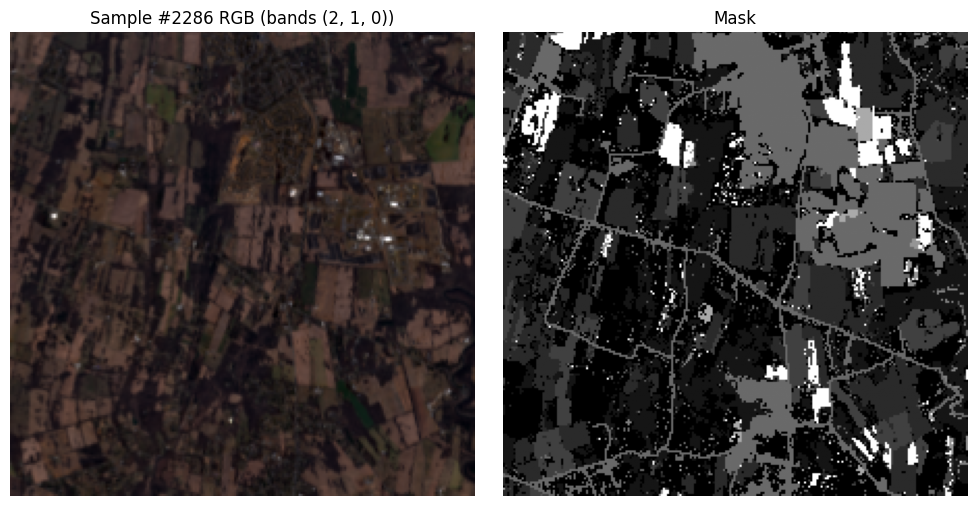

tensor([[[0.0245, 0.0251, 0.0281,  ..., 0.0938, 0.0874, 0.0961],
         [0.0261, 0.0238, 0.0256,  ..., 0.0632, 0.0614, 0.0601],
         [0.0240, 0.0230, 0.0215,  ..., 0.0552, 0.0511, 0.0481],
         ...,
         [0.1572, 0.1015, 0.0772,  ..., 0.0450, 0.0473, 0.0496],
         [0.1764, 0.1194, 0.0839,  ..., 0.0419, 0.0455, 0.0463],
         [0.1767, 0.1383, 0.0877,  ..., 0.0424, 0.0499, 0.0491]],

        [[0.0617, 0.0635, 0.0676,  ..., 0.1209, 0.1186, 0.1364],
         [0.0624, 0.0599, 0.0633,  ..., 0.0895, 0.0867, 0.0883],
         [0.0619, 0.0599, 0.0590,  ..., 0.0872, 0.0838, 0.0797],
         ...,
         [0.2224, 0.1610, 0.1387,  ..., 0.0754, 0.0804, 0.0902],
         [0.2486, 0.1826, 0.1412,  ..., 0.0708, 0.0779, 0.0877],
         [0.2418, 0.2029, 0.1450,  ..., 0.0729, 0.0824, 0.0888]],

        [[0.0415, 0.0438, 0.0489,  ..., 0.1417, 0.1314, 0.1475],
         [0.0421, 0.0410, 0.0444,  ..., 0.0969, 0.0931, 0.0905],
         [0.0434, 0.0408, 0.0423,  ..., 0.1003, 0.0920, 0.

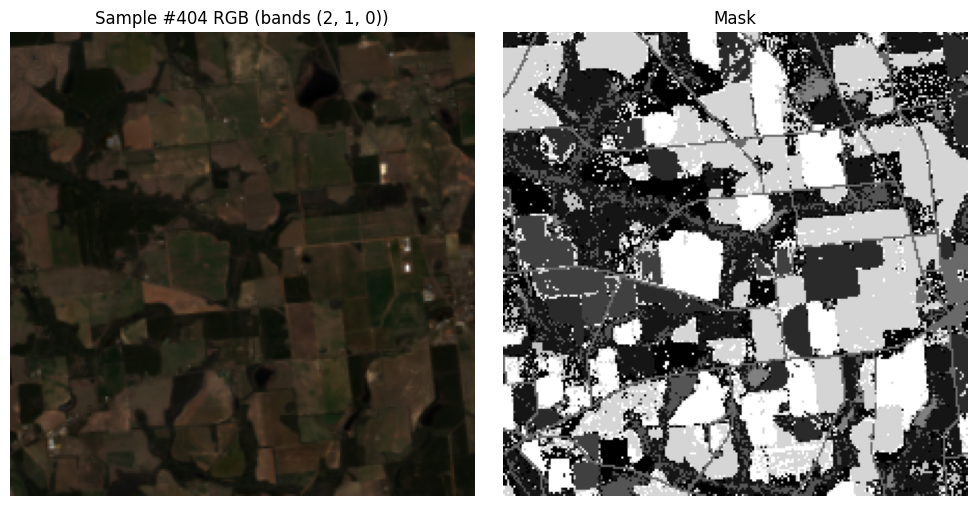

In [6]:
with open(os.path.join(SPLIT_DIR, 'dataset_splits.json')) as f:
    train_val_dataset = json.load(f)



# Create datasets
train_dataset, val_dataset = create_datasets(train_val_dataset, TRAINING_IMAGE_DIR, TRAINING_MASK_DIR)

# Create data loaders
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE)

visualize_random_rgb_sample(train_dataset)
visualize_random_rgb_sample(val_dataset)

In [7]:
model = DeepLabV3Plus(
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=18,
    classes=NUM_CLASSES,
    decoder_attention_type=DECODER_ATTENTION_TYPE,
    decoder_use_norm=DECODER_USER_NORM
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

focal_loss = FocalLoss(mode="multiclass", gamma=2.0)
tversky_loss =  TverskyLoss(
    mode='multiclass',
    ignore_index=0,
)

ce_loss = nn.CrossEntropyLoss( ignore_index = 0 );


def criterion(preds, targets):
    """
    preds: raw logits,   shape [B, C, H, W]
    targets: integer labels, shape [B, H, W]
    """
    # ensure integer dtype
    targets = targets.long()

    L_focal = focal_loss(preds, targets)

    return 1 * L_focal



scheduler = scheduler = PolynomialLR(
    optimizer,
    total_iters=EPOCHS,
    power=2.0,
    last_epoch=-1,
    verbose=True
)

In [8]:
accuracy = Accuracy(task="multiclass", average="macro",  num_classes=NUM_CLASSES).to(DEVICE)
iou = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
dice = DiceScore( num_classes=NUM_CLASSES, average="macro",   input_format="index" ).to(DEVICE)
miou = MeanIoU(num_classes=NUM_CLASSES, include_background= False,  input_format="index"  ).to(DEVICE)

Epoch 1/50:   0%|          | 0/78 [00:00<?, ?it/s]<ipython-input-5-657b4d567781>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))
Epoch 1/50: 100%|██████████| 78/78 [11:15<00:00,  8.66s/it]


[Epoch  0] Loss:  1.4287, Acc:   0.1174, IoU:   0.0558, Dice:  0.0549, mIoU:  0.0354


Epoch 1/50 [Val]: 100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


[Epoch  0] Loss: 1.1593, Acc: 0.1772, IoU: 0.0933, Dice: 0.0726, mIoU: 0.0526


Epoch 2/50: 100%|██████████| 78/78 [05:59<00:00,  4.61s/it]


[Epoch  1] Loss:  0.8695, Acc:   0.1959, IoU:   0.1111, Dice:  0.0945, mIoU:  0.0699


Epoch 2/50 [Val]: 100%|██████████| 20/20 [01:35<00:00,  4.79s/it]


[Epoch  1] Loss: 0.8626, Acc: 0.2391, IoU: 0.1302, Dice: 0.1028, mIoU: 0.0784


Epoch 3/50: 100%|██████████| 78/78 [05:56<00:00,  4.57s/it]


[Epoch  2] Loss:  0.7879, Acc:   0.2290, IoU:   0.1365, Dice:  0.1133, mIoU:  0.0874


Epoch 3/50 [Val]: 100%|██████████| 20/20 [01:21<00:00,  4.06s/it]


[Epoch  2] Loss: 0.7695, Acc: 0.2666, IoU: 0.1566, Dice: 0.1212, mIoU: 0.0960


Epoch 4/50: 100%|██████████| 78/78 [05:54<00:00,  4.54s/it]


[Epoch  3] Loss:  0.7470, Acc:   0.2786, IoU:   0.1705, Dice:  0.1271, mIoU:  0.0999


Epoch 4/50 [Val]: 100%|██████████| 20/20 [01:19<00:00,  3.99s/it]


[Epoch  3] Loss: 0.8231, Acc: 0.2849, IoU: 0.1735, Dice: 0.1264, mIoU: 0.1002


Epoch 5/50: 100%|██████████| 78/78 [05:52<00:00,  4.52s/it]


[Epoch  4] Loss:  0.7212, Acc:   0.2806, IoU:   0.1766, Dice:  0.1369, mIoU:  0.1087


Epoch 5/50 [Val]: 100%|██████████| 20/20 [01:33<00:00,  4.67s/it]


[Epoch  4] Loss: 0.7100, Acc: 0.3389, IoU: 0.2089, Dice: 0.1443, mIoU: 0.1159


Epoch 6/50: 100%|██████████| 78/78 [05:41<00:00,  4.38s/it]


[Epoch  5] Loss:  0.7026, Acc:   0.3203, IoU:   0.2052, Dice:  0.1456, mIoU:  0.1165


Epoch 6/50 [Val]: 100%|██████████| 20/20 [01:20<00:00,  4.03s/it]


[Epoch  5] Loss: 0.7053, Acc: 0.3540, IoU: 0.2184, Dice: 0.1492, mIoU: 0.1199


Epoch 7/50: 100%|██████████| 78/78 [05:52<00:00,  4.52s/it]


[Epoch  6] Loss:  0.6877, Acc:   0.3403, IoU:   0.2203, Dice:  0.1539, mIoU:  0.1240


Epoch 7/50 [Val]: 100%|██████████| 20/20 [01:33<00:00,  4.69s/it]


[Epoch  6] Loss: 0.7468, Acc: 0.3196, IoU: 0.2081, Dice: 0.1510, mIoU: 0.1221


Epoch 8/50: 100%|██████████| 78/78 [05:22<00:00,  4.14s/it]


[Epoch  7] Loss:  0.6738, Acc:   0.3549, IoU:   0.2328, Dice:  0.1619, mIoU:  0.1309


Epoch 8/50 [Val]: 100%|██████████| 20/20 [01:35<00:00,  4.77s/it]


[Epoch  7] Loss: 0.6779, Acc: 0.3445, IoU: 0.2255, Dice: 0.1640, mIoU: 0.1340


Epoch 9/50: 100%|██████████| 78/78 [05:57<00:00,  4.58s/it]


[Epoch  8] Loss:  0.6624, Acc:   0.3651, IoU:   0.2417, Dice:  0.1690, mIoU:  0.1375


Epoch 9/50 [Val]: 100%|██████████| 20/20 [01:33<00:00,  4.67s/it]


[Epoch  8] Loss: 0.6678, Acc: 0.3751, IoU: 0.2465, Dice: 0.1698, mIoU: 0.1385


Epoch 10/50: 100%|██████████| 78/78 [05:23<00:00,  4.14s/it]


[Epoch  9] Loss:  0.6535, Acc:   0.3769, IoU:   0.2508, Dice:  0.1755, mIoU:  0.1431


Epoch 10/50 [Val]: 100%|██████████| 20/20 [01:30<00:00,  4.55s/it]


[Epoch  9] Loss: 0.6753, Acc: 0.3700, IoU: 0.2418, Dice: 0.1708, mIoU: 0.1385


Epoch 11/50: 100%|██████████| 78/78 [05:40<00:00,  4.36s/it]


[Epoch 10] Loss:  0.6488, Acc:   0.3869, IoU:   0.2596, Dice:  0.1807, mIoU:  0.1477


Epoch 11/50 [Val]: 100%|██████████| 20/20 [01:01<00:00,  3.06s/it]


[Epoch 10] Loss: 0.6800, Acc: 0.3728, IoU: 0.2537, Dice: 0.1712, mIoU: 0.1405


Epoch 12/50: 100%|██████████| 78/78 [05:41<00:00,  4.38s/it]


[Epoch 11] Loss:  0.6396, Acc:   0.3949, IoU:   0.2663, Dice:  0.1862, mIoU:  0.1524


Epoch 12/50 [Val]: 100%|██████████| 20/20 [01:16<00:00,  3.84s/it]


[Epoch 11] Loss: 0.6491, Acc: 0.3731, IoU: 0.2492, Dice: 0.1825, mIoU: 0.1495


Epoch 13/50: 100%|██████████| 78/78 [05:34<00:00,  4.29s/it]


[Epoch 12] Loss:  0.6345, Acc:   0.3981, IoU:   0.2693, Dice:  0.1889, mIoU:  0.1550


Epoch 13/50 [Val]: 100%|██████████| 20/20 [01:31<00:00,  4.58s/it]


[Epoch 12] Loss: 0.6730, Acc: 0.4095, IoU: 0.2539, Dice: 0.1771, mIoU: 0.1439


Epoch 14/50: 100%|██████████| 78/78 [05:47<00:00,  4.45s/it]


[Epoch 13] Loss:  0.6237, Acc:   0.4125, IoU:   0.2808, Dice:  0.1948, mIoU:  0.1607


Epoch 14/50 [Val]: 100%|██████████| 20/20 [01:15<00:00,  3.75s/it]


[Epoch 13] Loss: 0.6639, Acc: 0.3959, IoU: 0.2644, Dice: 0.1834, mIoU: 0.1508


Epoch 15/50: 100%|██████████| 78/78 [05:25<00:00,  4.17s/it]


[Epoch 14] Loss:  0.6201, Acc:   0.4178, IoU:   0.2848, Dice:  0.1979, mIoU:  0.1635


Epoch 15/50 [Val]: 100%|██████████| 20/20 [01:32<00:00,  4.62s/it]


[Epoch 14] Loss: 0.6788, Acc: 0.3814, IoU: 0.2490, Dice: 0.1793, mIoU: 0.1460


Epoch 16/50: 100%|██████████| 78/78 [05:21<00:00,  4.13s/it]


[Epoch 15] Loss:  0.6193, Acc:   0.4170, IoU:   0.2855, Dice:  0.1985, mIoU:  0.1640


Epoch 16/50 [Val]: 100%|██████████| 20/20 [01:34<00:00,  4.71s/it]


[Epoch 15] Loss: 0.6347, Acc: 0.3987, IoU: 0.2659, Dice: 0.1848, mIoU: 0.1549


Epoch 17/50: 100%|██████████| 78/78 [05:54<00:00,  4.54s/it]


[Epoch 16] Loss:  0.6119, Acc:   0.4259, IoU:   0.2911, Dice:  0.2028, mIoU:  0.1682


Epoch 17/50 [Val]: 100%|██████████| 20/20 [01:02<00:00,  3.12s/it]


[Epoch 16] Loss: 0.6303, Acc: 0.4139, IoU: 0.2764, Dice: 0.1968, mIoU: 0.1640


Epoch 18/50: 100%|██████████| 78/78 [05:50<00:00,  4.49s/it]


[Epoch 17] Loss:  0.6059, Acc:   0.4357, IoU:   0.2985, Dice:  0.2060, mIoU:  0.1713


Epoch 18/50 [Val]: 100%|██████████| 20/20 [01:31<00:00,  4.57s/it]


[Epoch 17] Loss: 0.6366, Acc: 0.3919, IoU: 0.2695, Dice: 0.1920, mIoU: 0.1596


Epoch 19/50: 100%|██████████| 78/78 [05:11<00:00,  3.99s/it]


[Epoch 18] Loss:  0.5983, Acc:   0.4423, IoU:   0.3044, Dice:  0.2092, mIoU:  0.1748


Epoch 19/50 [Val]: 100%|██████████| 20/20 [01:29<00:00,  4.49s/it]


[Epoch 18] Loss: 0.6432, Acc: 0.3856, IoU: 0.2678, Dice: 0.1904, mIoU: 0.1589


Epoch 20/50: 100%|██████████| 78/78 [05:38<00:00,  4.34s/it]


[Epoch 19] Loss:  0.5975, Acc:   0.4455, IoU:   0.3070, Dice:  0.2105, mIoU:  0.1761


Epoch 20/50 [Val]: 100%|██████████| 20/20 [01:01<00:00,  3.08s/it]


[Epoch 19] Loss: 0.6279, Acc: 0.4198, IoU: 0.2807, Dice: 0.1970, mIoU: 0.1640


Epoch 21/50: 100%|██████████| 78/78 [05:44<00:00,  4.41s/it]


[Epoch 20] Loss:  0.5948, Acc:   0.4480, IoU:   0.3079, Dice:  0.2115, mIoU:  0.1767


Epoch 21/50 [Val]: 100%|██████████| 20/20 [01:32<00:00,  4.63s/it]


[Epoch 20] Loss: 0.6147, Acc: 0.4416, IoU: 0.2987, Dice: 0.2026, mIoU: 0.1701


Epoch 22/50: 100%|██████████| 78/78 [05:13<00:00,  4.02s/it]


[Epoch 21] Loss:  0.5873, Acc:   0.4554, IoU:   0.3149, Dice:  0.2147, mIoU:  0.1804


Epoch 22/50 [Val]: 100%|██████████| 20/20 [01:30<00:00,  4.54s/it]


[Epoch 21] Loss: 0.6201, Acc: 0.4085, IoU: 0.2835, Dice: 0.1986, mIoU: 0.1667


Epoch 23/50: 100%|██████████| 78/78 [05:48<00:00,  4.46s/it]


[Epoch 22] Loss:  0.5836, Acc:   0.4582, IoU:   0.3164, Dice:  0.2161, mIoU:  0.1817


Epoch 23/50 [Val]: 100%|██████████| 20/20 [01:04<00:00,  3.20s/it]


[Epoch 22] Loss: 0.6143, Acc: 0.4120, IoU: 0.2900, Dice: 0.2000, mIoU: 0.1686


Epoch 24/50: 100%|██████████| 78/78 [05:46<00:00,  4.44s/it]


[Epoch 23] Loss:  0.5793, Acc:   0.4634, IoU:   0.3220, Dice:  0.2190, mIoU:  0.1844


Epoch 24/50 [Val]: 100%|██████████| 20/20 [01:32<00:00,  4.60s/it]


[Epoch 23] Loss: 0.6242, Acc: 0.4316, IoU: 0.2920, Dice: 0.1989, mIoU: 0.1664


Epoch 25/50: 100%|██████████| 78/78 [05:18<00:00,  4.09s/it]


[Epoch 24] Loss:  0.5756, Acc:   0.4679, IoU:   0.3257, Dice:  0.2207, mIoU:  0.1860


Epoch 25/50 [Val]: 100%|██████████| 20/20 [01:33<00:00,  4.68s/it]


[Epoch 24] Loss: 0.6333, Acc: 0.4195, IoU: 0.2925, Dice: 0.2010, mIoU: 0.1679


Epoch 26/50: 100%|██████████| 78/78 [05:46<00:00,  4.44s/it]


[Epoch 25] Loss:  0.5790, Acc:   0.4643, IoU:   0.3219, Dice:  0.2195, mIoU:  0.1849


Epoch 26/50 [Val]: 100%|██████████| 20/20 [01:30<00:00,  4.54s/it]


[Epoch 25] Loss: 0.6177, Acc: 0.4237, IoU: 0.2942, Dice: 0.2091, mIoU: 0.1755


Epoch 27/50: 100%|██████████| 78/78 [05:15<00:00,  4.04s/it]


[Epoch 26] Loss:  0.5707, Acc:   0.4716, IoU:   0.3287, Dice:  0.2232, mIoU:  0.1888


Epoch 27/50 [Val]: 100%|██████████| 20/20 [01:30<00:00,  4.55s/it]


[Epoch 26] Loss: 0.6383, Acc: 0.4425, IoU: 0.2879, Dice: 0.2001, mIoU: 0.1655


Epoch 28/50: 100%|██████████| 78/78 [05:39<00:00,  4.35s/it]


[Epoch 27] Loss:  0.5632, Acc:   0.4806, IoU:   0.3356, Dice:  0.2257, mIoU:  0.1916


Epoch 28/50 [Val]: 100%|██████████| 20/20 [01:01<00:00,  3.07s/it]


[Epoch 27] Loss: 0.6085, Acc: 0.4342, IoU: 0.3028, Dice: 0.2102, mIoU: 0.1776


Epoch 29/50: 100%|██████████| 78/78 [05:41<00:00,  4.38s/it]


[Epoch 28] Loss:  0.5673, Acc:   0.4833, IoU:   0.3371, Dice:  0.2268, mIoU:  0.1927


Epoch 29/50 [Val]: 100%|██████████| 20/20 [01:27<00:00,  4.38s/it]


[Epoch 28] Loss: 0.6109, Acc: 0.4318, IoU: 0.2962, Dice: 0.2161, mIoU: 0.1811


Epoch 30/50: 100%|██████████| 78/78 [05:16<00:00,  4.06s/it]


[Epoch 29] Loss:  0.5585, Acc:   0.4866, IoU:   0.3404, Dice:  0.2289, mIoU:  0.1945


Epoch 30/50 [Val]: 100%|██████████| 20/20 [01:28<00:00,  4.40s/it]


[Epoch 29] Loss: 0.6108, Acc: 0.4516, IoU: 0.3076, Dice: 0.2105, mIoU: 0.1770


Epoch 31/50: 100%|██████████| 78/78 [05:27<00:00,  4.20s/it]


[Epoch 30] Loss:  0.5593, Acc:   0.4829, IoU:   0.3375, Dice:  0.2278, mIoU:  0.1936


Epoch 31/50 [Val]: 100%|██████████| 20/20 [01:17<00:00,  3.89s/it]


[Epoch 30] Loss: 0.5954, Acc: 0.4382, IoU: 0.3056, Dice: 0.2124, mIoU: 0.1797


Epoch 32/50: 100%|██████████| 78/78 [05:36<00:00,  4.31s/it]


[Epoch 31] Loss:  0.5520, Acc:   0.4920, IoU:   0.3452, Dice:  0.2303, mIoU:  0.1965


Epoch 32/50 [Val]: 100%|██████████| 20/20 [01:00<00:00,  3.01s/it]


[Epoch 31] Loss: 0.5869, Acc: 0.4534, IoU: 0.3142, Dice: 0.2187, mIoU: 0.1848


Epoch 33/50: 100%|██████████| 78/78 [05:43<00:00,  4.40s/it]


[Epoch 32] Loss:  0.5478, Acc:   0.5000, IoU:   0.3517, Dice:  0.2336, mIoU:  0.1998


Epoch 33/50 [Val]: 100%|██████████| 20/20 [01:30<00:00,  4.52s/it]


[Epoch 32] Loss: 0.5895, Acc: 0.4699, IoU: 0.3195, Dice: 0.2242, mIoU: 0.1905


Epoch 34/50: 100%|██████████| 78/78 [05:09<00:00,  3.97s/it]


[Epoch 33] Loss:  0.5486, Acc:   0.4972, IoU:   0.3493, Dice:  0.2331, mIoU:  0.1990


Epoch 34/50 [Val]: 100%|██████████| 20/20 [01:30<00:00,  4.54s/it]


[Epoch 33] Loss: 0.5851, Acc: 0.4526, IoU: 0.3175, Dice: 0.2144, mIoU: 0.1828


Epoch 35/50: 100%|██████████| 78/78 [05:41<00:00,  4.38s/it]


[Epoch 34] Loss:  0.5412, Acc:   0.5038, IoU:   0.3552, Dice:  0.2356, mIoU:  0.2020


Epoch 35/50 [Val]: 100%|██████████| 20/20 [01:00<00:00,  3.03s/it]


[Epoch 34] Loss: 0.5902, Acc: 0.4507, IoU: 0.3105, Dice: 0.2204, mIoU: 0.1869


Epoch 36/50: 100%|██████████| 78/78 [05:43<00:00,  4.40s/it]


[Epoch 35] Loss:  0.5437, Acc:   0.5063, IoU:   0.3572, Dice:  0.2365, mIoU:  0.2028


Epoch 36/50 [Val]: 100%|██████████| 20/20 [01:30<00:00,  4.54s/it]


[Epoch 35] Loss: 0.5850, Acc: 0.4607, IoU: 0.3187, Dice: 0.2197, mIoU: 0.1871


Epoch 37/50: 100%|██████████| 78/78 [05:13<00:00,  4.03s/it]


[Epoch 36] Loss:  0.5417, Acc:   0.5076, IoU:   0.3574, Dice:  0.2367, mIoU:  0.2032


Epoch 37/50 [Val]: 100%|██████████| 20/20 [01:28<00:00,  4.45s/it]


[Epoch 36] Loss: 0.6284, Acc: 0.4397, IoU: 0.2904, Dice: 0.2072, mIoU: 0.1740


Epoch 38/50: 100%|██████████| 78/78 [05:27<00:00,  4.19s/it]


[Epoch 37] Loss:  0.5483, Acc:   0.5029, IoU:   0.3539, Dice:  0.2356, mIoU:  0.2018


Epoch 38/50 [Val]: 100%|██████████| 20/20 [01:20<00:00,  4.00s/it]


[Epoch 37] Loss: 0.5954, Acc: 0.4479, IoU: 0.3085, Dice: 0.2222, mIoU: 0.1889


Epoch 39/50: 100%|██████████| 78/78 [05:47<00:00,  4.45s/it]


[Epoch 38] Loss:  0.5402, Acc:   0.5095, IoU:   0.3592, Dice:  0.2387, mIoU:  0.2048


Epoch 39/50 [Val]: 100%|██████████| 20/20 [01:32<00:00,  4.62s/it]


[Epoch 38] Loss: 0.6056, Acc: 0.4513, IoU: 0.3019, Dice: 0.2154, mIoU: 0.1812


Epoch 40/50: 100%|██████████| 78/78 [05:17<00:00,  4.07s/it]


[Epoch 39] Loss:  0.5419, Acc:   0.5050, IoU:   0.3566, Dice:  0.2381, mIoU:  0.2039


Epoch 40/50 [Val]: 100%|██████████| 20/20 [01:29<00:00,  4.47s/it]


[Epoch 39] Loss: 0.6359, Acc: 0.4519, IoU: 0.2982, Dice: 0.2101, mIoU: 0.1769


Epoch 41/50: 100%|██████████| 78/78 [05:39<00:00,  4.36s/it]


[Epoch 40] Loss:  0.5410, Acc:   0.5001, IoU:   0.3528, Dice:  0.2372, mIoU:  0.2032


Epoch 41/50 [Val]: 100%|██████████| 20/20 [01:01<00:00,  3.05s/it]


[Epoch 40] Loss: 0.5822, Acc: 0.4641, IoU: 0.3252, Dice: 0.2243, mIoU: 0.1910


Epoch 42/50: 100%|██████████| 78/78 [05:41<00:00,  4.37s/it]


[Epoch 41] Loss:  0.5315, Acc:   0.5147, IoU:   0.3645, Dice:  0.2414, mIoU:  0.2080


Epoch 42/50 [Val]: 100%|██████████| 20/20 [01:01<00:00,  3.09s/it]


[Epoch 41] Loss: 0.5938, Acc: 0.4535, IoU: 0.3198, Dice: 0.2205, mIoU: 0.1881


Epoch 43/50: 100%|██████████| 78/78 [05:51<00:00,  4.51s/it]


[Epoch 42] Loss:  0.5268, Acc:   0.5203, IoU:   0.3698, Dice:  0.2437, mIoU:  0.2104


Epoch 43/50 [Val]: 100%|██████████| 20/20 [01:30<00:00,  4.54s/it]


[Epoch 42] Loss: 0.6132, Acc: 0.4487, IoU: 0.3055, Dice: 0.2152, mIoU: 0.1803


Epoch 44/50: 100%|██████████| 78/78 [05:43<00:00,  4.40s/it]


[Epoch 43] Loss:  0.5463, Acc:   0.5018, IoU:   0.3537, Dice:  0.2366, mIoU:  0.2024


Epoch 44/50 [Val]: 100%|██████████| 20/20 [01:01<00:00,  3.06s/it]


[Epoch 43] Loss: 0.6133, Acc: 0.4457, IoU: 0.3026, Dice: 0.2077, mIoU: 0.1758


Epoch 45/50: 100%|██████████| 78/78 [05:37<00:00,  4.32s/it]


[Epoch 44] Loss:  0.5273, Acc:   0.5191, IoU:   0.3691, Dice:  0.2436, mIoU:  0.2104


Epoch 45/50 [Val]: 100%|██████████| 20/20 [01:30<00:00,  4.53s/it]


[Epoch 44] Loss: 0.6037, Acc: 0.4337, IoU: 0.3068, Dice: 0.2166, mIoU: 0.1849


Epoch 46/50: 100%|██████████| 78/78 [05:07<00:00,  3.94s/it]


[Epoch 45] Loss:  0.5335, Acc:   0.5104, IoU:   0.3615, Dice:  0.2408, mIoU:  0.2070


Epoch 46/50 [Val]: 100%|██████████| 20/20 [01:26<00:00,  4.34s/it]


[Epoch 45] Loss: 0.6008, Acc: 0.4458, IoU: 0.3074, Dice: 0.2193, mIoU: 0.1860


Epoch 47/50: 100%|██████████| 78/78 [05:10<00:00,  3.98s/it]


[Epoch 46] Loss:  0.5297, Acc:   0.5227, IoU:   0.3724, Dice:  0.2454, mIoU:  0.2122


Epoch 47/50 [Val]: 100%|██████████| 20/20 [01:30<00:00,  4.51s/it]


[Epoch 46] Loss: 0.6035, Acc: 0.4521, IoU: 0.3136, Dice: 0.2200, mIoU: 0.1857


Epoch 48/50: 100%|██████████| 78/78 [05:39<00:00,  4.36s/it]


[Epoch 47] Loss:  0.5359, Acc:   0.5137, IoU:   0.3636, Dice:  0.2419, mIoU:  0.2083


Epoch 48/50 [Val]: 100%|██████████| 20/20 [01:00<00:00,  3.03s/it]


[Epoch 47] Loss: 0.5914, Acc: 0.4746, IoU: 0.3198, Dice: 0.2254, mIoU: 0.1911


Epoch 49/50: 100%|██████████| 78/78 [05:44<00:00,  4.41s/it]


[Epoch 48] Loss:  0.5277, Acc:   0.5214, IoU:   0.3710, Dice:  0.2460, mIoU:  0.2124


Epoch 49/50 [Val]: 100%|██████████| 20/20 [01:32<00:00,  4.64s/it]


[Epoch 48] Loss: 0.5780, Acc: 0.4794, IoU: 0.3302, Dice: 0.2287, mIoU: 0.1951


Epoch 50/50: 100%|██████████| 78/78 [05:20<00:00,  4.11s/it]


[Epoch 49] Loss:  0.5237, Acc:   0.5247, IoU:   0.3740, Dice:  0.2461, mIoU:  0.2128


Epoch 50/50 [Val]: 100%|██████████| 20/20 [01:29<00:00,  4.47s/it]

[Epoch 49] Loss: 0.5894, Acc: 0.4610, IoU: 0.3166, Dice: 0.2244, mIoU: 0.1905


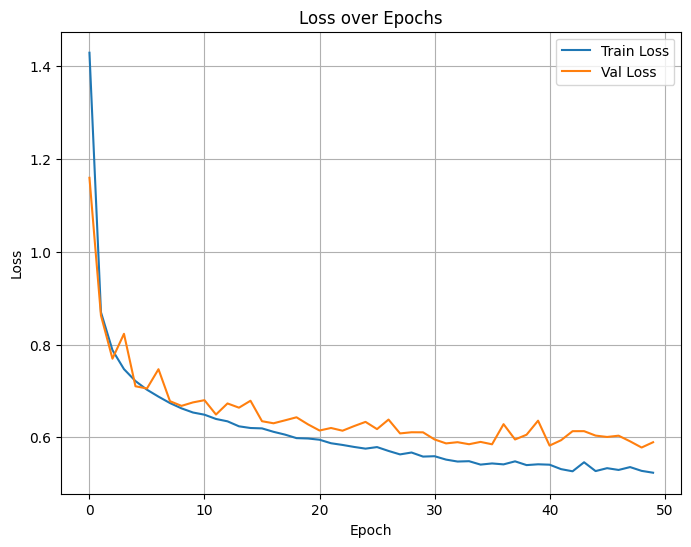

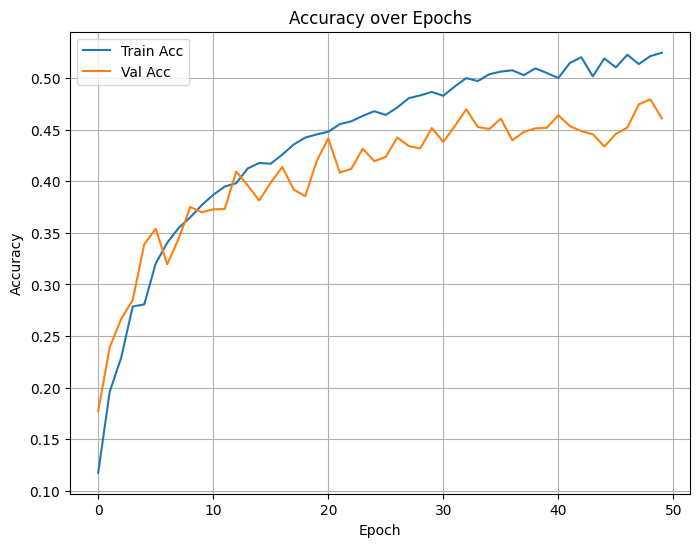

In [9]:


writer = SummaryWriter(log_dir="runs/experiment1")

labels = {
      0: "No Data",
      1: "Natural Vegetation",
      2: "Forest",
      3: "Corn",
      4: "Soybeans",
      5: "Wetlands",
      6: "Developed Barren",
      7: "Open Water",
      8: "Winter Wheat",
      9: "Alfalfa",
      10: "Fallow Idle Cropland",
      11: "Cotton",
      12: "Sorghum",
      13: "Other"
  }

train_losses, train_accs, train_ious, train_mious, train_dices = [], [], [], [], []
val_losses,   val_accs,   val_ious,   val_mious,  val_dices = [], [], [], [], []
best_val_acc = 0.0
best_epoch     = 0
best_model_wts = None

for epoch in range(EPOCHS):
    model.train()
    train_loss_sum = train_acc_sum = train_iou_sum = train_dice_sum = train_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    ### ——— TRAIN ———
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)

        accuracy.update(preds, masks)
        iou      .update(preds, masks)
        dice     .update(preds, masks)
        miou     .update(preds, masks)

        train_loss_sum  += loss.item()

    # Average metrics
    train_losses.append(train_loss_sum / len(train_loader))
    train_accs  .append(accuracy.compute().item())
    train_ious  .append(iou.compute().item())
    train_dices .append(dice.compute().item())
    train_mious .append(miou.compute().item())

    writer.add_scalar('Loss/train', train_losses[-1], epoch)
    writer.add_scalar('Accuracy/train', train_accs[-1], epoch)
    writer.add_scalar('IoU/train', train_ious[-1], epoch)
    writer.add_scalar('Dice/train', train_dices[-1], epoch)
    writer.add_scalar('mIoU/train', train_mious[-1], epoch)


    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss:  {train_losses[-1]:.4f}, "
        f"Acc:   {train_accs[-1]:.4f}, "
        f"IoU:   {train_ious[-1]:.4f}, "
        f"Dice:  {train_dices[-1]:.4f}, "
        f"mIoU:  {train_mious[-1]:.4f}"
    )

    ### ——— VALIDATION ———
    model.eval()
    val_loss_sum = val_acc_sum = val_iou_sum = val_dice_sum = val_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)

            preds = torch.argmax(outputs, dim=1)

            accuracy.update(preds, masks)
            iou      .update(preds, masks)
            dice     .update(preds, masks)
            miou     .update(preds, masks)

            val_loss_sum  += loss.item()

    # Average metrics
    val_acc = accuracy.compute().item()
    val_losses.append(val_loss_sum / len(val_loader))
    val_accs  .append(val_acc)
    val_ious  .append(iou.compute().item())
    val_dices .append(dice.compute().item())
    val_mious .append(miou.compute().item())

    # Log to TensorBoard
    writer.add_scalar('Loss/val', val_losses[-1], epoch)
    writer.add_scalar('Accuracy/val', val_accs[-1], epoch)
    writer.add_scalar('IoU/val', val_ious[-1], epoch)
    writer.add_scalar('Dice/val', val_dices[-1], epoch)
    writer.add_scalar('mIoU/val', val_mious[-1], epoch)

    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss: {val_losses[-1]:.4f}, "
        f"Acc: {val_accs[-1]:.4f}, "
        f"IoU: {val_ious[-1]:.4f}, "
        f"Dice: {val_dices[-1]:.4f}, "
        f"mIoU: {val_mious[-1]:.4f}"
    )

    # Scheduler step on validation loss
    scheduler.step(val_losses[-1])

    if val_acc > best_val_acc:
        best_val_acc   = val_acc
        best_epoch     = epoch + 1
        best_model_wts = copy.deepcopy(model.state_dict())


model.load_state_dict(best_model_wts)

# After training, plot metrics separately
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_accs,  label='Train Acc')
plt.plot(val_accs,    label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Close TensorBoard writer
writer.close()


Saved Loss plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_loss_20250517-000645_normalized_polynomial_focal_shuffle.png


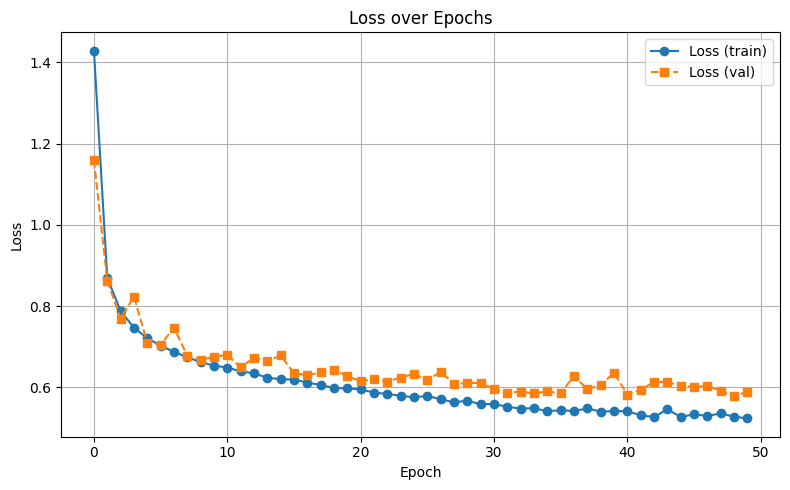

Saved Accuracy plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_accuracy_20250517-000645_normalized_polynomial_focal_shuffle.png


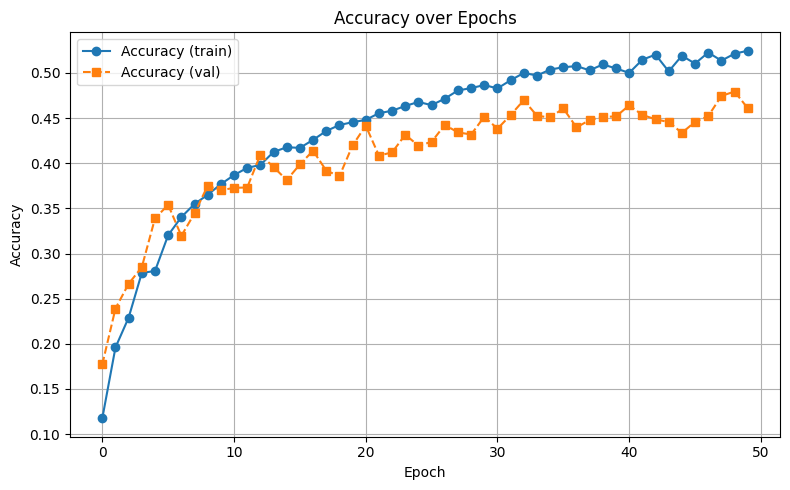

Saved Iou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_iou_20250517-000645_normalized_polynomial_focal_shuffle.png


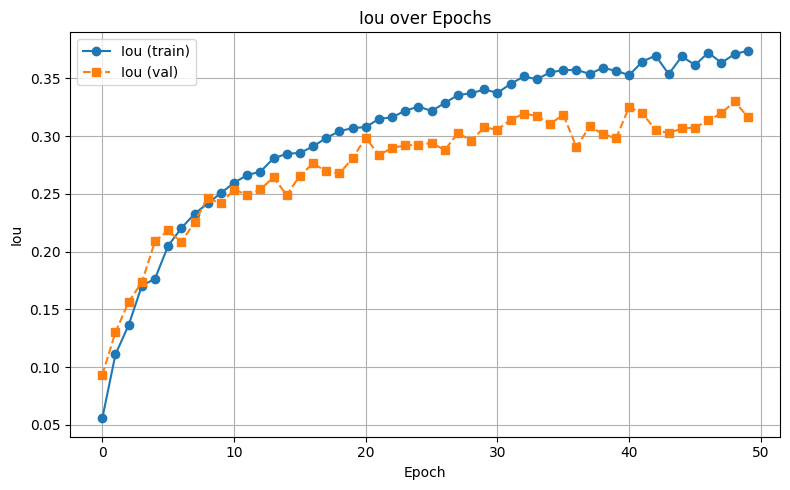

Saved Dice plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_dice_20250517-000645_normalized_polynomial_focal_shuffle.png


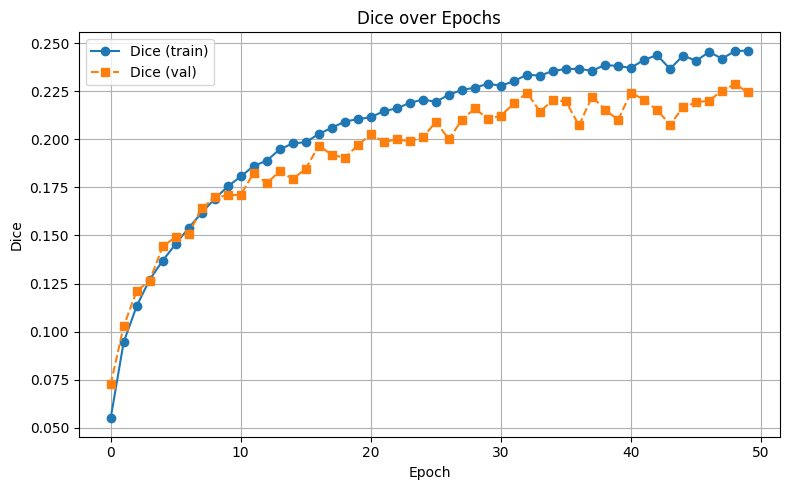

Saved Miou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_miou_20250517-000645_normalized_polynomial_focal_shuffle.png


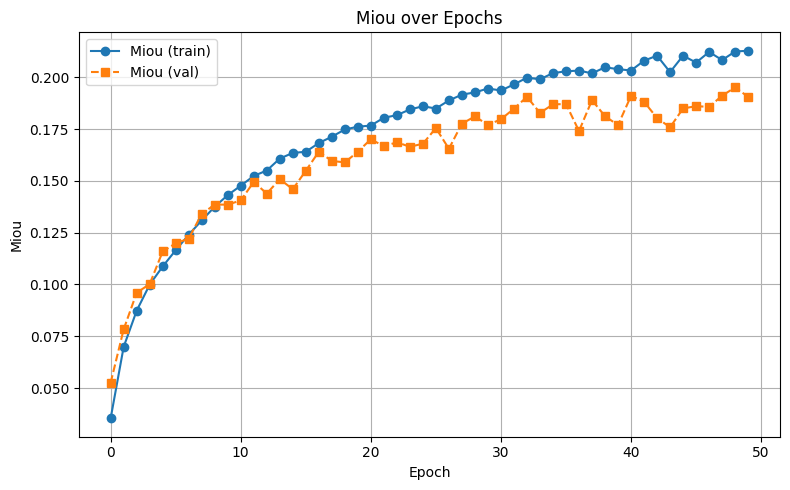

In [10]:
timestamp = time.strftime("%Y%m%d-%H%M%S")

all_metrics = {
    'loss':  (train_losses, val_losses),
    'accuracy': (train_accs, val_accs),
    'iou':    (train_ious, val_ious),
    'dice':   (train_dices, val_dices),
    'miou':   (train_mious, val_mious),
}

for metric_name, (train_vals, val_vals) in all_metrics.items():
    plt.figure(figsize=(8, 5))
    plt.plot(train_vals, marker='o', linestyle='-', label=f'{metric_name.title()} (train)')
    plt.plot(val_vals,   marker='s', linestyle='--', label=f'{metric_name.title()} (val)')
    plt.title(f'{metric_name.title()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # build a descriptive filename
    filename = (
        f"deeplabv3+_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
        f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_"
        f"{metric_name}_{timestamp}_normalized_polynomial_focal_shuffle.png"
    )
    save_path = os.path.join(UNET_GRAPH_FOLDER, filename)

    # save and show
    plt.savefig(save_path, dpi=300)
    print(f"Saved {metric_name.title()} plot to: {save_path}")
    plt.show()

In [11]:

os.makedirs(UNET_MODEL_FOLDER, exist_ok=True)

model_filename = (
    f"deeplabv3+_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_"
    f"lr{LEARNING_RATE:.0e}_normalized_polynomial_focal_shuffle.pth"
)

model_path = os.path.join(UNET_MODEL_FOLDER, model_filename)


torch.save(model.state_dict(), model_path)
print(f"Saved model checkpoint to: {model_path}")


Saved model checkpoint to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/models/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_normalized_polynomial_focal_shuffle.pth


In [12]:
os.makedirs(UNET_METRICS_FOLDER, exist_ok=True)

# Build a DataFrame with both train & val metrics
metrics_df = pd.DataFrame({
    'Epoch':        list(range(1, len(train_losses) + 1)),
    'train_Loss':   train_losses,
    'train_Acc':    train_accs,
    'train_IoU':    train_ious,
    'train_Dice':   train_dices,
    'train_mIoU':   train_mious,
    'val_Loss':     val_losses,
    'val_Acc':      val_accs,
    'val_IoU':      val_ious,
    'val_Dice':     val_dices,
    'val_mIoU':     val_mious,
})

# Descriptive filename using your hyper-params
csv_filename = (
    f"deeplabv3+_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_normalized_polynomial_focal_shuffle_metrics.csv"
)
csv_path = os.path.join(UNET_METRICS_FOLDER, csv_filename)

# Save!
metrics_df.to_csv(csv_path, index=False)
print(f"Saved all train/val metrics to: {csv_path}")


Saved all train/val metrics to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/metrics/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_normalized_polynomial_focal_shuffle_metrics.csv
